In [1]:
# I/O / data wrangling
import os
import glob
import re
import numpy as np
import xarray as xr
import xcdat as xc

# runtime metrics
import time as clocktime

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

# define a lambda function to perform natural sort
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s)]

In [2]:
cmipTable = {
    "pr": "Amon",
    "psl": "Amon",
    "tas": "Amon",
    "zmta": "Amon",
    "tos": "Omon",
    "siconc": "OImon",
    "monmaxpr": "Aday",
    "monmaxtasmax": "Aday",
    "monmintasmin": "Aday",
}
cmipVar = {
    "pr": "pr",
    "psl": "psl",
    "tas": "tas",
    "zmta": "ta",
    "tos": "tos",
    "siconc": "siconc",
    "monmaxpr": "pr",
    "monmaxtasmax": "tasmax",
    "monmintasmin": "tasmin",
}
evalPeriods = {
    "Tier1": ("1950-01-01", "2022-12-31"),
    "Tier2": ("1900-01-01", "2022-12-31"),
    "Tier3": ("1979-01-01", "2022-12-31"),
}
nlat = 72
nlon = 144

### Define user-specified parameters

In [3]:
root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/"  # path to forcesmip data (NCAR)

outdir = "ForceSMIP_output/"  # directory where output data should be saved

ncvar = "tos"  # CMIP variable name to be used

# choose models for training
# choices include: 'CESM2', 'CanESM5', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR'
training_models = ["CESM2","CanESM5","MIROC-ES2L","MIROC6","MPI-ESM1-2-LR"]
n_members = 10  # number of members for training

# choose evaluation data
eval_tier = "Tier1"  # Tier1, Tier2, or Tier3

# no need to modify the training or reference period for LFCA
tv_time_period = evalPeriods[eval_tier] # ("1950-01-01","2022-12-30")  # period of time to consider data for training
reference_period = tv_time_period # anomalies will be with respect to mean over entire period (convectional for LFCA)

In [4]:
def load_realization(fn, vid, time_period, reference_period):
    """
    load_realization(fn, vid, time_period, reference_period)
    
    Function loads in data for a given file, fn, and variable, vid. It
    selects data for a given time_period and calculates the anomalies
    relative to a user-defined reference_period. The function returns arrays
    of the dimensions (time, lat, lon), the 3D anomaly map, and the global
    mean time series. 
    
    Inputs:
    -------
    fn (str) : filename
    vid (str) : variable id
    time_period (tuple(str, str)) : tuple of the start and end of the time period
                                    e.g., ("1900-01-01", "1949-12-31")
    reference_period (tuple(str, str)) : tuple of the start and end of the reference period
                                         used to calculate anomalies e.g., ("1900-01-01", "1949-12-31")
                                         
    Returns:
    --------
    ts_3d (xr.DataArray) : monthly average anomaly values [time, lat, lon]
    ts_gm (xr.DataArray) : monthly average, global mean anomaly values
    """
    # open dataset
    ds = xc.open_dataset(fn)
    # if specified, subset training/validation data to specific period
    if tv_time_period is not None:
        ds = ds.sel(time=slice(time_period[0], time_period[1]))
    # get departures
    ds = ds.temporal.departures(vid, freq="month", reference_period=reference_period)
    # If you wanted annual averages instead, you could use the following:
    # ds = ds.temporal.group_average(vid, freq="year", weighted=False)
    ts_3d = ds[vid]
    # take spatial average
    ds = ds.spatial.average(vid)
    ts_gm = ds[vid]
    # clean up 
    ds.close()
    # return values
    return ts_3d, ts_gm

In [5]:
# initialize dictionary to store data
global_mean_timeseries = {}
anomaly_maps = {}
anomaly_map_emean = {}
missing_data_mask_training = {}
vid = cmipVar[ncvar]
# loop over models
models = training_models
for im, model in enumerate([models[0]]):
    # start timer
    stime = clocktime.time()
    # initialize nested dictionary for model data
    global_mean_timeseries[model] = {}
    anomaly_maps[model] = {}
    anomaly_map_emean[model] = 0
    missing_data_mask_training[model] = {}
    # get model files
    mpath = "/".join([root_dir, "Training", cmipTable[ncvar], ncvar, model])
    mfiles = glob.glob(mpath + "/*.nc")
    # parse file names to get list of model members
    # CESM2 has a non-CMIP naming convention
    if model == "CESM2":
        members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
    else:
        members = [p.split("_")[-1].split(".")[0] for p in mfiles]
    members = sorted(members, key=natsort)
    # print progress
    print(str(im + 1) + " / " + str(len(models)) + ": " + model + " (" + str(len(members)) + " members)")
    # loop over model members
    for imm, member in enumerate(members):
        # define member filename
        fn = glob.glob(mpath + "/*_" + member + ".*.nc")
        # make sure filename is unique
        if len(fn) != 1:
            raise ValueError("Unexpected number of model members")
        else:
            fn = fn[0]
        # load data for realization
        ts_3d, ts_gm = load_realization(fn, vid, tv_time_period, reference_period)
        # store first N anomaly maps from training models
        # also store all data for the validation models
        if ((imm < n_members) & (model in training_models)):# | (model in validation_models):
            # store masked data in array
            anomaly_maps[model][member] = ts_3d
        # ensemble mean anomaly map
        anomaly_map_emean[model] = anomaly_map_emean[model] + ts_3d/len(members)
        # save global mean time series for all model members
        global_mean_timeseries[model][member] = ts_gm
        # create mask for missing data
        tmp = np.mean(ts_3d, axis=0)
        missing_data_mask_training[model] = np.where(np.isnan(tmp), np.nan, 1)
        # update progress
        print(".", end="")
    # print time elapse for model
    etime = clocktime.time()
    print()
    print("Time elapsed: " + str(etime - stime) + " seconds")
    print()

1 / 5: CESM2 (50 members)
..................................................
Time elapsed: 101.60173559188843 seconds



In [6]:
# example of how to get the ensemble member names for CESM2, one of the training models
k = list(anomaly_maps['CESM2'].keys())

In [7]:
# example of how to extract the anomaly map for the first training map of CESM2
anomalies = anomaly_maps['CESM2'][k[0]]
# the ensemble mean anomalies have the same size, but are the mean over all members of the chosen training model
anomalies_emean = anomaly_map_emean['CESM2']

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
lm = LinearRegression()

In [10]:
emean_array = anomalies_emean.values

In [14]:
lm_array = np.empty((72, 144))

lm_array[:] = np.nan

lm_array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [16]:
lm = LinearRegression()

In [17]:
tmp_X = np.arange(876).reshape((-1, 1))

for i in np.arange(72):
    for j in np.arange(144):
        tmp_data = emean_array[:, i, j]
        
        if np.any(np.isnan(tmp_data)):
            continue
        else:
            lm_array[i, j] = lm.fit(X = tmp_X,
                                    y = tmp_data).coef_[0]


In [18]:
lm_array.shape

(72, 144)

In [20]:
lats = anomalies_emean.lat
lons = anomalies_emean.lon

In [21]:
lm_da = xr.DataArray(lm_array,
                     coords = {'lat': lats, 'lon': lons},
                     dims = ['lat', 'lon'])

In [22]:
lm_array2 = lm_array * 875 

In [23]:
lm_d2 = xr.DataArray(lm_array2,
                     coords = {'lat': lats, 'lon': lons},
                     dims = ['lat', 'lon'])

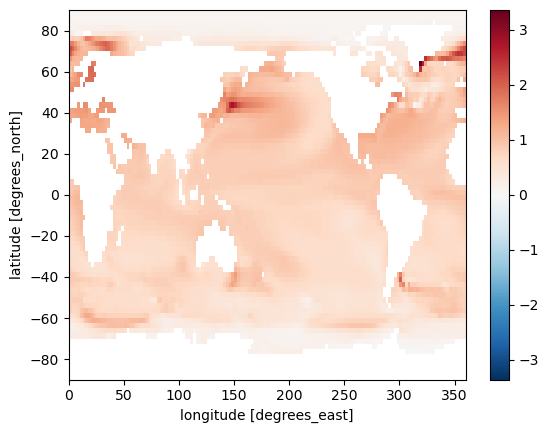

In [24]:
lm_d2.plot();